# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Инструкция по выполнению проекта

Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Это редкие случаи, которые легко пропустить, если всегда применять только бустинг. Поэкспериментируйте и сравните характеристики моделей: скорость работы, точность результата.
Загрузите и подготовьте данные.
Обучите разные модели. Для каждой попробуйте различные гиперпараметры.
Проанализируйте скорость работы и качество моделей.
Примечания:
Для оценки качества моделей применяйте метрику RMSE.
Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
Поскольку модель градиентного бустинга может обучаться долго, измените у неё только два-три параметра.
Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del:
Скопировать код
PYTHON
del features_train 

# Описание данных

Данные находятся в файле /datasets/autos.csv

# Признаки

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox  — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

# Целевой признак

- Price — цена (евро)

## Подготовка данных

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from sklearn.preprocessing import OrdinalEncoder
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from lightgbm import LGBMRegressor
import warnings
warnings.simplefilter('ignore')

In [2]:
# Открываем файл с данными
auto = pd.read_csv('/datasets/autos.csv')

In [3]:
# Первые 5 строк
auto.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
# Информация
auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


Что мы имеем из визуального анализа на данном этапе:
 - DateCrawled (дата скачивания анкеты) этот признак для обучения модели нам не понадобится;
 - Price (цена) этот признак у нас целевой, в этом столбце у нас нет пропущенных значений;
 - VehicleType (тип кузова) это признак нам необходим для обучения, в этом столбце имеются пропущенные значения;
 - RegistrationYear (год регистрации) этот признак важен для обучения, пропущенных значений нет;
 - Gearbox (тип к.п.) этот признак важен для обучения, имеются пропущенные значения;
 - Power (мощность л.с.) важный признак для обучения, нет пропущенных значений;
 - Model этот признак важен для обучения,имеются пропущенные значения;
 - Kilometer (пробег) признак важен, пропусков нет;
 - RegistrationMonth (месяц регистрации) признак важен для обучения, пропусков нет;
 - FuelType (тип топлива) признак важен для обучения, имеются пропуски;
 - Brand признак важен для обучения, пропусков нет;
 - NotRepaired (ремонт да/нет) важный признак для обучения, большое количество пропущенных значений, более 20%;
 - DateCreated (дата создания анкеты) не важный признак;
 - NumberOfPictures (количество фотографий автомобиля) неважный признак;
 - PostalCode (почтовый индекс) не важный признак;
 - LastSeen (последняя активность) не важный признак.
 
 Так же в датасете несколько признаков категориальных, следовательно необходимо будет применить технику прямого кодирования.
 
 Пропущенные значения имеются исключительно в категориальных признаках.

In [5]:
# Наличие дубликатов
auto.duplicated().sum()

4

In [6]:
# Избавимся от дубликатов
auto = auto.drop_duplicates().reset_index(drop=True)

In [7]:
# Значения признака "год выпуска"
auto['RegistrationYear'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

In [8]:
# Сделаем срез с адекватными годами выпуска
auto = auto.query('1900 < RegistrationYear < 2021')

In [9]:
# Значения признака "месяц регистрации"
auto['RegistrationMonth'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [10]:
# Нулевые значения месяца регистрации 
auto[auto['RegistrationMonth'] == 0]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11 00:00:00,0,24148,2016-03-19 08:46:47
16,2016-04-01 12:46:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01 00:00:00,0,38871,2016-04-01 12:46:46
36,2016-03-11 11:50:37,1600,other,1991,manual,75,kadett,70000,0,NaN,opel,NaN,2016-03-11 00:00:00,0,2943,2016-04-07 03:46:09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354301,2016-04-03 13:46:24,3500,NaN,1995,NaN,0,polo,150000,0,NaN,volkswagen,NaN,2016-04-03 00:00:00,0,74579,2016-04-05 12:44:38
354314,2016-03-15 19:57:11,400,wagon,1991,manual,0,legacy,150000,0,petrol,subaru,NaN,2016-03-15 00:00:00,0,24558,2016-03-19 15:49:00
354322,2016-03-31 19:36:18,1300,small,1999,manual,75,2_reihe,125000,0,NaN,peugeot,NaN,2016-03-31 00:00:00,0,35102,2016-04-06 13:44:44
354325,2016-03-30 20:55:30,350,small,1996,NaN,65,punto,150000,0,NaN,fiat,NaN,2016-03-30 00:00:00,0,25436,2016-04-07 13:50:41


In [11]:
# Сделаем срез с адекватными значениями месяца регистрации
auto = auto.query('0 < RegistrationMonth')

In [12]:
# Удалим из нашего датасета столбцы с неважными признаками
auto.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode', 'NumberOfPictures'], axis=1, inplace=True)

In [13]:
# Уникальные значения целевого столбца
auto['Price'].sort_values().unique()

array([    0,     1,     2, ..., 19998, 19999, 20000])

In [14]:
# Нулевые значения в цене
auto[auto['Price'] == 0]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
7,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no
40,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN
111,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN
152,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes
466,0,NaN,2016,auto,197,3er,150000,12,gasoline,bmw,no
...,...,...,...,...,...,...,...,...,...,...,...
354154,0,NaN,2000,manual,55,punto,5000,5,petrol,fiat,yes
354234,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,NaN
354244,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,NaN
354273,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes


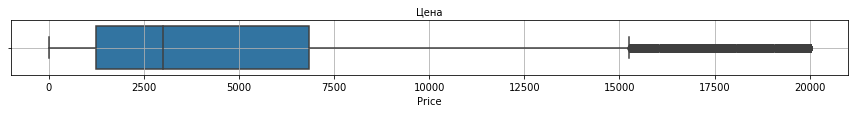

In [15]:
# Ящик с усами для Price
plt.figure(figsize=(15,1))
sns.boxplot(auto['Price'], orient='h')
plt.title('Цена', fontsize=10)
plt.grid(True)
plt.show()

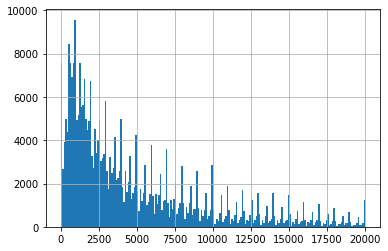

In [16]:
# Гистограмма распределения
auto['Price'].hist(bins=200)

In [17]:
# Список характерных значений
auto['Price'].describe()

count    316974.000000
mean       4712.542578
std        4585.623188
min           0.000000
25%        1250.000000
50%        2999.000000
75%        6850.000000
max       20000.000000
Name: Price, dtype: float64

Что можно сказать о целевом признаке:
- есть очень странный пик около 0; 
- диаграмма размаха скошена вправо;
- распределение скорее экспоненциональное;
- значения идут сериями по несколько.

Возможно, сбор данных был произведен неправильно, так как ожидалось нормальное распределение цены. 

In [18]:
# Сделаем более правдоподобный срез, на которм цена будет более 200, но менее 15500
auto = auto.query('15500  > Price > 200')

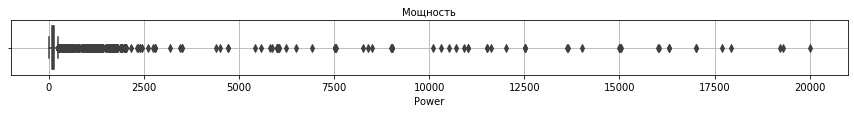

In [19]:
# Ящик с усами для Price
plt.figure(figsize=(15,1))
sns.boxplot(auto['Power'], orient='h')
plt.title('Мощность', fontsize=10)
plt.grid(True)
plt.show()

Неадекватно выглядят данные по мощности, сделаем срез по мощности до 1500, т.к. автомобилей с такой мощностью не бывает.

In [20]:
# Сделаем более правдоподобный срез, на которм мощность будет менее 1500
auto = auto.query('1500  > Power')

In [21]:
# Сброс индексации
auto.index = range(len(auto.index))

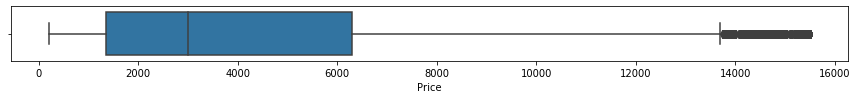

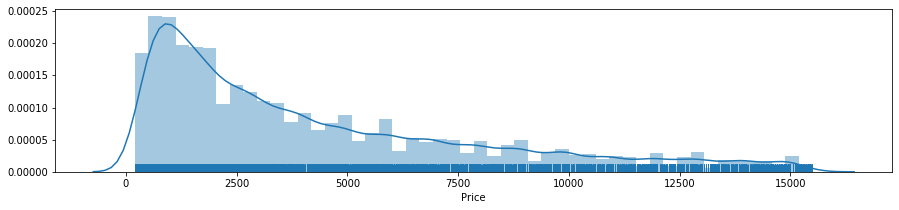

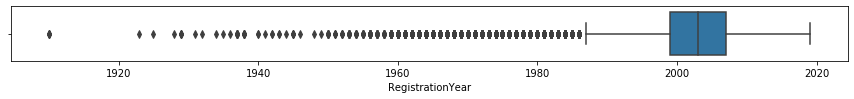

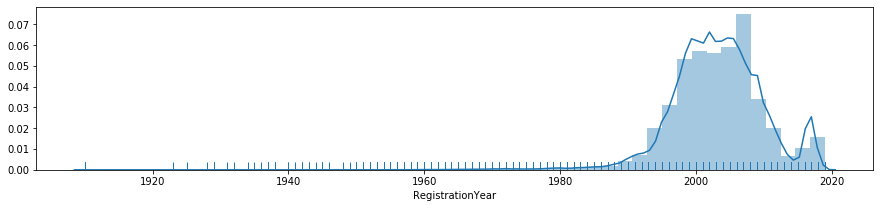

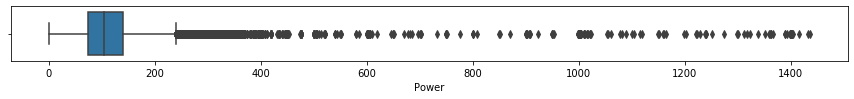

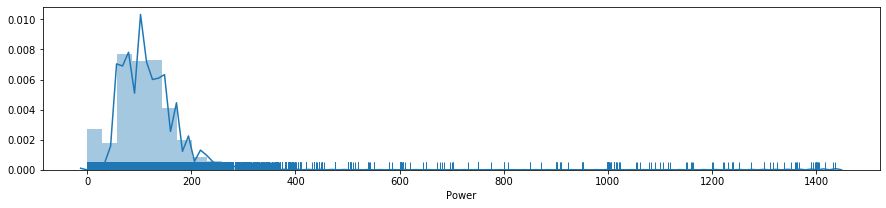

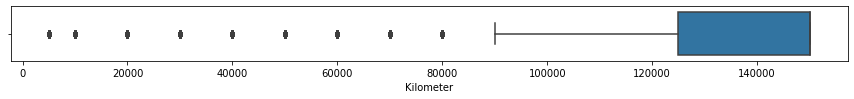

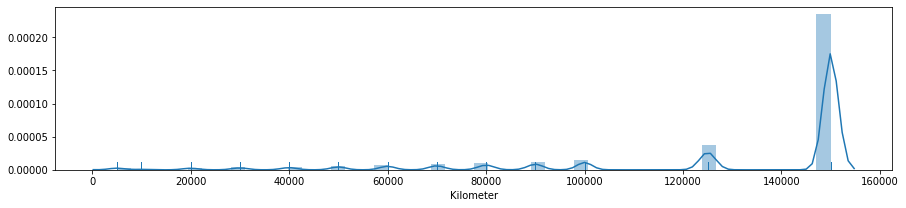

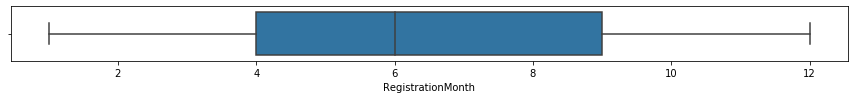

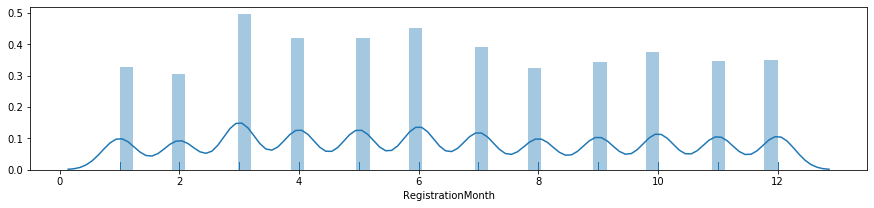

In [22]:
# Еще раз посмотрим на данные после очистки
for i in ['Price','RegistrationYear','Power','Kilometer','RegistrationMonth']:
    plt.figure(figsize=(15,1))
    sns.boxplot(auto[i]);
    plt.show()
    plt.figure(figsize=(15,3))
    ax = sns.distplot(auto[i], rug=True);
    plt.show()

Чуть лучше выглядят данные, хоть и не идеальны на мой взгляд

In [23]:
# Посмотрим на матрицу корреляций
auto.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
Price,1.000000,0.399607,0.420924,-0.338969,0.014383
RegistrationYear,0.399607,1.000000,0.066244,-0.212020,0.011441
Power,0.420924,0.066244,1.000000,0.110029,0.011320
Kilometer,-0.338969,-0.212020,0.110029,1.000000,0.008829
RegistrationMonth,0.014383,0.011441,0.011320,0.008829,1.000000


Явных зависимостей не обнаружено

Так как у нас пропущенные значения имеются только в категориальных переменных, мы можем пропуски заменить на, допустим,  "нет значения", чтобы замена не привела к искривлению данных.

In [24]:
# Замена пропусков
auto = auto.fillna('nodata')

In [25]:
# Проверка
auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291457 entries, 0 to 291456
Data columns (total 11 columns):
Price                291457 non-null int64
VehicleType          291457 non-null object
RegistrationYear     291457 non-null int64
Gearbox              291457 non-null object
Power                291457 non-null int64
Model                291457 non-null object
Kilometer            291457 non-null int64
RegistrationMonth    291457 non-null int64
FuelType             291457 non-null object
Brand                291457 non-null object
NotRepaired          291457 non-null object
dtypes: int64(5), object(6)
memory usage: 24.5+ MB


In [26]:
# Разделим датасет на признаки и целевой признак
features = auto.drop(['Price'], axis=1)
target = auto['Price']

In [27]:
# Применим технику прямого кодирования(ohe) для категориальных переменных в датасете
auto_ohe = pd.get_dummies(auto, drop_first=True)

In [28]:
# Применим технику порядкового кодирования(Ordinal Encoding) для категориальных переменных в датасете
features_enc = features.copy()
categorical_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
encoder = OrdinalEncoder()
features_enc[categorical_features] = encoder.fit_transform(features_enc[categorical_features])

In [29]:
# Выделим признаки в датасете с применением ohe
features_ohe = auto_ohe.drop(['Price'], axis=1)

In [30]:
# Разделим данные на обучающую и на тестовую выборки, 
# получатся выборки без кодирования, с прямым кодированием и порядковым кодированием
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=20202021)
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(features_ohe, target, test_size=0.25, random_state=20202021)
features_train_enc, features_test_enc = train_test_split(features_enc, test_size=0.25, random_state=20202021)

In [31]:
# Проверим
print('Соотношения:')
print('обучающая', round(features_train.shape[0] / features.shape[0], 2))
print('тестовая', round(features_test.shape[0] / features.shape[0], 2))
print('обучающая ohe', round(features_train_ohe.shape[0] / features_ohe.shape[0], 2))
print('тестовая ohe', round(features_test_ohe.shape[0] / features_ohe.shape[0], 2))
print('обучающая ordinal', round(features_train_enc.shape[0] / features_enc.shape[0], 2))
print('тестовая ordinal', round(features_test_enc.shape[0] / features_enc.shape[0], 2))
print()

Соотношения:
обучающая 0.75
тестовая 0.25
обучающая ohe 0.75
тестовая ohe 0.25
обучающая ordinal 0.75
тестовая ordinal 0.25



In [32]:
# Применим масштабирование признаков, 
# чтобы исключить доминацию одних признаков над другими
numeric = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])

# Вывод 
- Исходные данные: 16 признаков и 354369 наблюдений;
- Были обнаружены пропуски в категориальных признаках, и, так как это категориальные признаки , попуски были заполнены 'nodata';
- целевой признак 'Price' имеет экспоненциональное распределение с пиком около 0, явные неадекватные значения были удалены;
- Неадекватно большие и малые значения были удалены из признака 'RegistrationYear' и 'Power';
- Явных корреляций между признаками обнаружено не было;
- К категориальным признакам была применена техника прямого кодирования;
- Данные были разделены на обучающую и тестовую выборки в размере 0.75/0.25

## Обучение моделей

In [33]:
# Создадим таблицу для показателей моделей
model_time_rmse = pd.DataFrame(columns=('model','fit_time','score_time','RMSE'))
model_time_rmse.head()

,model,fit_time,score_time,RMSE


Decision Tree Regressor

In [34]:
# Дерево решений регрессия, автоматический подбор гиперпараметров
model_DTR = DecisionTreeRegressor(random_state=20202021)
parametr_DTR = {'max_depth': range (1, 16)}
gs_DTR = GridSearchCV(model_DTR, parametr_DTR, cv = 5, scoring = 'neg_mean_squared_error')
gs_DTR.fit(features_train_enc, target_train)
print('максимальная глубина дерева', gs_DTR.best_params_)

максимальная глубина дерева {'max_depth': 13}


In [35]:
# Строка в таблице с показателями
dtr = ['DecisionTreeRegressor']
# Обучим и посчитаем время обучения
model_DTR = DecisionTreeRegressor(random_state=20202021, max_depth = 15)
start = time.time()
model_DTR.fit(features_train_enc, target_train)
end=time.time()
# добавим в строку время обучения
dtr.append(end-start)
# Предскажем и посчитаем время предсказания
start = time.time()
predictions_DTR = model_DTR.predict(features_test_enc)
end=time.time()
# добавим в строку время обучения
dtr.append(end-start)
rmse_DTR = mean_squared_error(target_test, predictions_DTR)**(0.5)
# добавим rmse в строку 
dtr.append(rmse_DTR)
# Добавим строку в таблицу с показателями
model_time_rmse.loc[len(model_time_rmse)] = dtr
model_time_rmse.head()

,model,fit_time,score_time,RMSE
0,DecisionTreeRegressor,0.867971,0.020011,1680.690178


Random Forest Regressor

In [36]:
# Случайный лес регрессия, автоматический подбор гиперпараметоров 
model_RFR = RandomForestRegressor(random_state=20202021)
parametrs_RFR = {'n_estimators': range (10, 21, 10),
             'max_depth': range (1, 6, 1)}
gs_RFR = GridSearchCV(model_RFR, parametrs_RFR, scoring = 'neg_mean_squared_error', cv=5)
gs_RFR.fit(features_train_enc, target_train)
print('лучшие параметры', gs_RFR.best_params_)

лучшие параметры {'max_depth': 5, 'n_estimators': 20}


In [37]:
# Строка в таблице с показателями
rfr = ['RandomForestRegressor']
# Обучим и посчитаем время обучения
model_RFR = RandomForestRegressor(max_depth = 5, n_estimators = 20, random_state=20202021)
start = time.time()
model_RFR.fit(features_train_enc, target_train)
end=time.time()
# добавим в строку время обучения
rfr.append(end-start)
# Предскажем и посчитаем время предсказания
start = time.time()
predictions_RFR = model_RFR.predict(features_test_enc)
end=time.time()
# добавим в строку время обучения
rfr.append(end-start)
rmse_RFR = mean_squared_error(target_test, predictions_RFR)**(0.5)
# добавим rmse в строку 
rfr.append(rmse_RFR)
# Добавим строку в таблицу с показателями
model_time_rmse.loc[len(model_time_rmse)] = rfr
model_time_rmse.head()

,model,fit_time,score_time,RMSE
0,DecisionTreeRegressor,0.867971,0.020011,1680.690178
1,RandomForestRegressor,4.361338,0.072354,2151.682566


Linear Regression

In [38]:
# Линейная регрессия, автоматический подбор гиперпараметоров 
model_LR = LinearRegression()
parametrs_LR = {'fit_intercept':[True,False], 
                   'normalize':[True,False]}
gs_LR = GridSearchCV(model_LR, param_grid = parametrs_LR, scoring = 'neg_mean_squared_error', cv=5)
gs_LR.fit(features_train_ohe, target_train_ohe)
print('лучшие параметры', gs_LR.best_params_)

лучшие параметры {'fit_intercept': True, 'normalize': False}


In [39]:
# Строка в таблице с показателями
lr = ['LinearRegression']
# Обучим и посчитаем время обучения
model_LR = LinearRegression(fit_intercept = True, normalize = False)
start = time.time()
model_LR.fit(features_train_ohe, target_train_ohe)
end=time.time()
# добавим в строку время обучения
lr.append(end-start)
# Предскажем и посчитаем время предсказания
start = time.time()
predictions_LR = gs_LR.predict(features_test_ohe)
end=time.time()
# добавим в строку время обучения
lr.append(end-start)
rmse_LR = mean_squared_error(target_test_ohe, predictions_LR)**(0.5)
# добавим rmse в строку 
lr.append(rmse_LR)
# Добавим строку в таблицу с показателями
model_time_rmse.loc[len(model_time_rmse)] = lr
model_time_rmse.head()

,model,fit_time,score_time,RMSE
0,DecisionTreeRegressor,0.867971,0.020011,1680.690178
1,RandomForestRegressor,4.361338,0.072354,2151.682566
2,LinearRegression,23.598017,0.225335,2283.473932


LightGBM

In [40]:
# Поменяем тип данных для обучения LightGBM
categorical = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
for column in categorical:
    features_train[column] = features_train[column].astype('category')
    features_test[column] = features_test[column].astype('category')

In [41]:
# модель LightGBM с подбором гиперпараметров
model_lgbm = LGBMRegressor()
parametrs_lgbm = {'learning_rate': [0.01, 0.8],
             'max_depth': [1, 8]}
gs_lgbm = GridSearchCV(model_lgbm, parametrs_lgbm, scoring = 'neg_mean_squared_error', cv=5)
gs_lgbm.fit(features_train, target_train)
print('лучшие параметры', gs_lgbm.best_params_)

лучшие параметры {'learning_rate': 0.8, 'max_depth': 8}


In [ ]:
#LGBMRegressor()
model_lgbm = LGBMRegressor()
parametrs_lgbm = {'learning_rate': [0.01, 0.8],
             'max_depth': [1, 8]}
tss = TimesSeriesSplit(n_splits = 5)
gs_lgbm = GridSearchCV(model_lgbm, parametrs_lgbm,scoring = 'neg_mean_squared_error',cv=tss)
gs_lgbm.fit(features_train, target_train)
print('лучшие параметры', gs_lgbm.best_params_)

In [ ]:
# Обучим
model_lgbm = LGBMRegressor(learning_rate = 0.8, max_depth = 8)
model_lgbm.fit(features_train, target_train)
# Прогноз
predictions_lgbm = gs_lgbm.predict(features_test)
rmse_lgbm = mean_squared_error(target_test, predictions_lgbm)**(0.5)
rmse_lgbm

In [42]:
# Строка в таблице с показателями
lgbm = ['LGBMRegressor']
# Обучим и посчитаем время обучения
model_lgbm = LGBMRegressor(learning_rate = 0.8, max_depth = 8)
start = time.time()
model_lgbm.fit(features_train, target_train)
end=time.time()
# добавим в строку время обучения
lgbm.append(end-start)
# Предскажем и посчитаем время предсказания
start = time.time()
predictions_lgbm = gs_lgbm.predict(features_test)
end=time.time()
# добавим в строку время обучения
lgbm.append(end-start)
rmse_lgbm = mean_squared_error(target_test, predictions_lgbm)**(0.5)
# добавим rmse в строку 
lgbm.append(rmse_lgbm)
# Добавим строку в таблицу с показателями
model_time_rmse.loc[len(model_time_rmse)] = lgbm
model_time_rmse.head()

,model,fit_time,score_time,RMSE
0,DecisionTreeRegressor,0.867971,0.020011,1680.690178
1,RandomForestRegressor,4.361338,0.072354,2151.682566
2,LinearRegression,23.598017,0.225335,2283.473932
3,LGBMRegressor,5.995037,0.706576,1467.462079


# Вывод
Были обучены 4 модели:
- Decision Tree Regressor;
- Random Forest Regressor;
- Linear Regression;
- LightGBM

## Анализ моделей

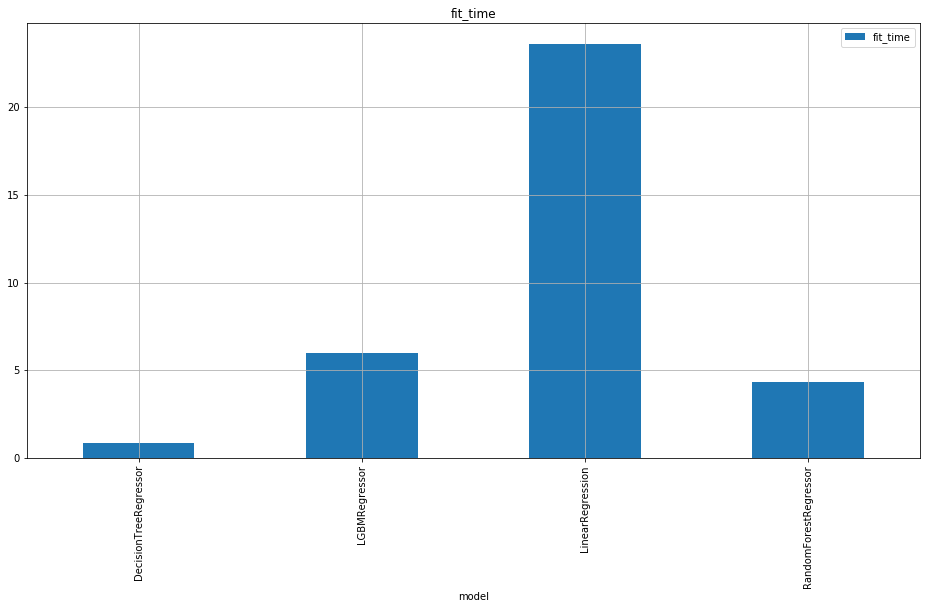

In [43]:
# Визуализируем полученные результаты, график "Время обучения"
ax = model_time_rmse.pivot_table(index = 'model', values = 'fit_time').plot(figsize=(16, 8), grid=True, kind='bar', title='fit_time')
plt.show()

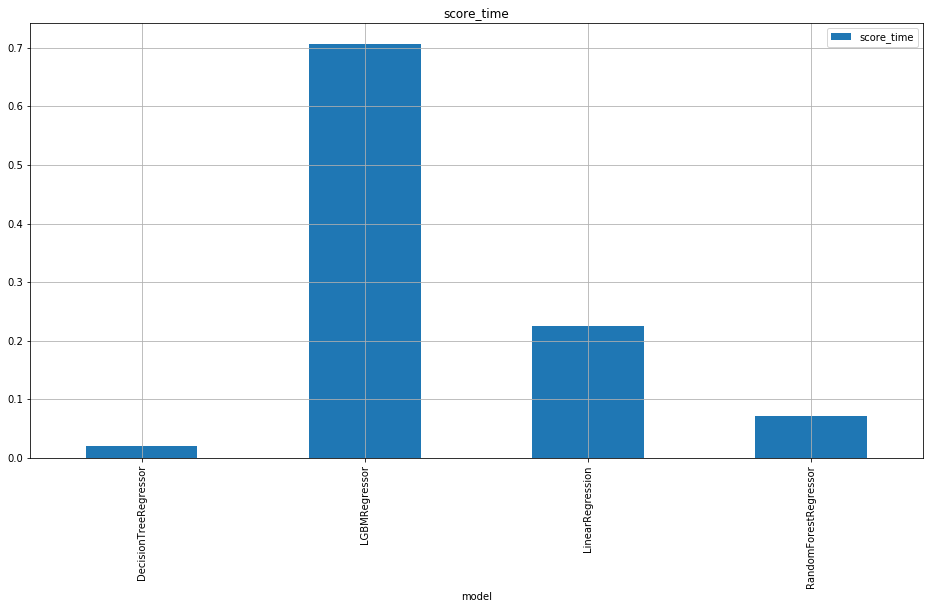

In [44]:
# Визуализируем полученные результаты, график "Время предсказания"
ax = model_time_rmse.pivot_table(index = 'model', values = 'score_time').plot(figsize=(16, 8), grid=True, kind='bar', title='score_time')
plt.show()

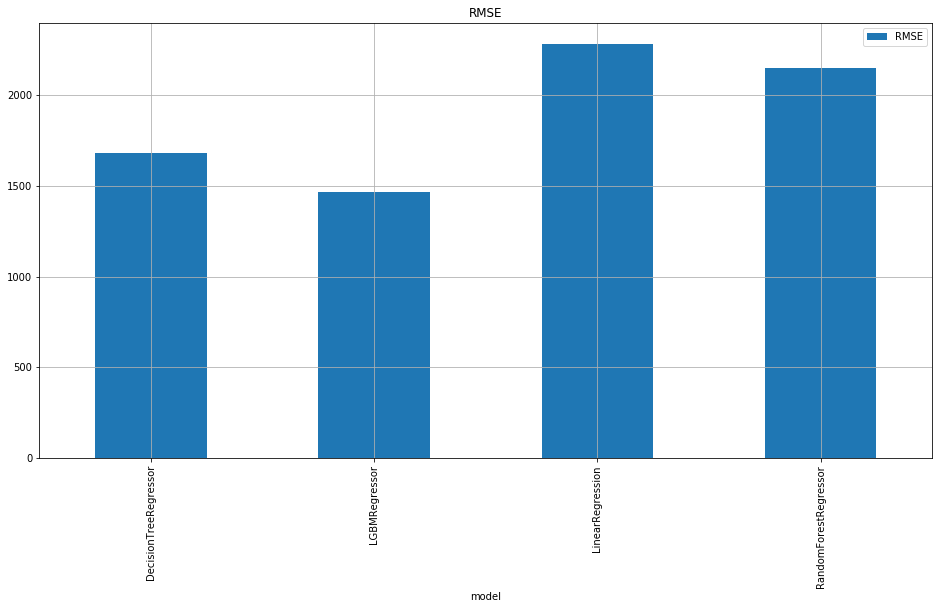

In [45]:
# Визуализируем полученные результаты, график "Метрика RMSE"
ax = model_time_rmse.pivot_table(index = 'model', values = 'RMSE').plot(figsize=(16, 8), grid=True, kind='bar', title='RMSE')
plt.show()

# Вывод
- По времени обучения лидирует модель дерево решений, а аутсайдер по времени обучения - линейная регрессия, она показывает наибольшее время обучения. Минимальное время предсказания опять же у дерева решений, а максимальное время обучения у LightGBM. Наименьшее(наилучшее) значение метрики корня из среднеквадратичной ошибки у модели LightGBM(1467), а наибольшее(наихудшее) значение показала модель линейная регрессия(2283). Модели дерево решений и LightGBM показали наилучшие результаты из 4 обученных моделей.

# Общий вывод 

# 1

- Исходные данные: 16 признаков и 354369 наблюдений;
- Были обнаружены пропуски в категориальных признаках, и, так как это категориальные признаки , попуски были заполнены 'nodata';
- целевой признак 'Price' имеет экспоненциональное распределение с пиком около 0, явные неадекватные значения были удалены;
- Неадекватно большие и малые значения были удалены из признака 'RegistrationYear' и 'Power';
- Явных корреляций между признаками обнаружено не было;
- К категориальным признакам была применена техника прямого кодирования;
- Данные были разделены на обучающую и тестовую выборки в размере 0.75/0.25

# 2

Были обучены 4 модели:
- Decision Tree Regressor;
- Random Forest Regressor;
- Linear Regression;
- LightGBM

# 3

- По времени обучения лидирует модель дерево решений, а аутсайдер по времени обучения - линейная регрессия, она показывает наибольшее время обучения. Минимальное время предсказания опять же у дерева решений, а максимальное время обучения у LightGBM. Наименьшее(наилучшее) значение метрики корня из среднеквадратичной ошибки у модели LightGBM(1467), а наибольшее(наихудшее) значение показала модель линейная регрессия(2283). Модели дерево решений и LightGBM показали наилучшие результаты из 4 обученных моделей.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей